In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.decomposition import PCA
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import pprint

----

### Access response vector and behaviral data:

Here we show an example that has pupil area data.

In [2]:
boc = BrainObservatoryCache()
# get data, experiment id grabbed from filtered experiments:
data_set = boc.get_ophys_experiment_data(508546728)

In [3]:
# look at meta data:
pprint.pprint(data_set.get_metadata())

{'age_days': 78,
 'cre_line': 'Scnn1a-Tg3-Cre/wt',
 'device': 'Nikon A1R-MP multiphoton microscope',
 'device_name': 'CAM2P.2',
 'excitation_lambda': '910 nanometers',
 'experiment_container_id': 511510955,
 'fov': '400x400 microns (512 x 512 pixels)',
 'genotype': 'Scnn1a-Tg3-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt',
 'imaging_depth_um': 275,
 'indicator': 'GCaMP6f',
 'ophys_experiment_id': 508546728,
 'pipeline_version': '3.0',
 'session_start_time': datetime.datetime(2016, 3, 17, 9, 17, 15),
 'session_type': 'three_session_B',
 'sex': 'male',
 'specimen_name': 'Scnn1a-Tg3-Cre;Camk2a-tTA;Ai93-231951',
 'targeted_structure': 'VISp'}


In [4]:
# grab relevant variables:
time, dff_traces = data_set.get_dff_traces()
stim_table = data_set.get_stimulus_table('natural_movie_one')
running_speed = data_set.get_running_speed()[1]
pupil_size = data_set.get_pupil_size()[1] 

In [5]:
# 90 neuron traces x 113866 frames for this experiment:
dff_traces.shape

(90, 113866)

In [6]:
# aligned behavior measurement:
pupil_size.shape

(113866,)

Let's get response vectors & aligned block-averaged behaviors:

In [7]:
# global variables  
# 30 blocks, 1 movie is 900 frame, and 10 repeats for natural_movie_1
n_divs = 30
n_frames = 900
n_repeats = 10
frames_per_repeat = int(n_frames/n_divs)

def response_vals(data_set):
    '''
    input: dataset of an experiment;
    output: block averaged traces (response vecs), pupil areas and running speed.
    '''
    _, dff_traces = data_set.get_dff_traces()
    stim_table = data_set.get_stimulus_table('natural_movie_one')
    running_speed = data_set.get_running_speed()[1]
    pupil_size = data_set.get_pupil_size()[1] 

    n_cells = dff_traces.shape[0]

    dff_vals = np.zeros((n_repeats, n_divs, n_cells))
    ppl_vals = np.zeros((n_repeats, n_divs))
    run_vals = np.zeros((n_repeats, n_divs))

    # for each repeat:
    for repeat_idx in range(n_repeats):
        # grab all frames belongs to the repeat
        repeat_frames = np.array(stim_table.query('repeat == @repeat_idx')['start'])
        # for each block:
        for div_idx in range(n_divs):
            # grab block frames
            div_repeat_idxs = repeat_frames[
                div_idx*frames_per_repeat:(div_idx+1)*frames_per_repeat]     
            # average over block frames:
            dff_vals[repeat_idx, div_idx] = np.mean(dff_traces[:, div_repeat_idxs], axis=1)
            ppl_vals[repeat_idx, div_idx] = np.nanmean(pupil_size[div_repeat_idxs]) # there are NaNs
            run_vals[repeat_idx, div_idx] = np.mean(running_speed[div_repeat_idxs])
    
    return dff_vals, ppl_vals, run_vals

In [8]:
dff_vals, ppl_vals, run_vals = response_vals(data_set)

/Users/xinzheng/opt/anaconda3/envs/rep-drift/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: Mean of empty slice


In [9]:
# response vector dimension is 90, 
# which stand for the n (neuron) dimensional vector, 
# for the particular block (m = 30) for that repeat (p = 10) 
dff_vals.shape

(10, 30, 90)

-----

### Calculate within session correlation:

Let's calculate the within session __Pearson correlation__, and __the angle $\theta$ between response vectors__. The two matrices should look qualitatively very similar.

Notice that the corcoeff matrix makes sense for some experiment (there are correlation cross repeats for the same block), but look more noisy for others. The below one is noisy.

In [10]:
# helper func:
def get_align_angle(x, y):
    'input: two vectors of same length; output: angle between vec in degrees'
    dot = np.dot(x,y)/(
         np.linalg.norm(x) * np.linalg.norm(y))
    if dot > 1.0:
         dot = 1.0
    elif dot < -1.0:
        dot = -1.0
    
    return 180/np.pi * np.arccos(dot)

In [11]:
def calc_similarity(dff_vals):
    '''
    input: response vectors 
    output: correlation coef. matrix & angle matrix
    '''
    within_session_corrs = np.zeros((n_repeats*n_divs, n_repeats*n_divs))
    within_session_angles = np.zeros((n_repeats*n_divs, n_repeats*n_divs))

    for repeat_idx1 in range(n_repeats):
        for repeat_idx2 in range(n_repeats):
            # corrcoef for all blocks in repeat_1 and repeat_2:
            within_session_corrs[ 
                repeat_idx1*n_divs : (repeat_idx1+1)*n_divs, 
                repeat_idx2*n_divs : (repeat_idx2+1)*n_divs] = np.corrcoef(
                    # return 30x30 R-values:
                    dff_vals[repeat_idx1], dff_vals[repeat_idx2])[n_divs:, :n_divs] # for some reason corrcoef returns 4 copies of this matrix
            
            for div_idx1 in range(n_divs):
                for div_idx2 in range(n_divs):
                    # calculate angle 
                    # for resp_vec of block_1 in repeat_1 and
                    #  resp_vec in block_2 in repeat_2:
                    within_session_angles[
                        repeat_idx1 * n_divs + div_idx1, 
                        repeat_idx2 * n_divs + div_idx2] = get_align_angle(
                            dff_vals[repeat_idx1, div_idx1], 
                            dff_vals[repeat_idx2, div_idx2])

    return within_session_corrs, within_session_angles

In [12]:
within_session_corrs, within_session_angles = calc_similarity(dff_vals)

In [13]:
# plot functions for corrs and angles: (Fig. 2c style)
# plot first 5 repeats of 10 to prevent overly crowded:

n_repeat_plot = 5

def plot_corr(corrs):
    _, ax = plt.subplots(1, 1, figsize=(9.5,8))

    sns.heatmap(corrs[:n_repeat_plot*n_divs, :n_repeat_plot*n_divs], 
                cmap = 'PRGn', vmin = -1, vmax = 1,
                ax = ax)

    tick_locs = [n_divs/2 + i * n_divs for i in range(n_repeat_plot)]
    ax.set_xticks(tick_locs)
    ax.set_yticks(tick_locs)
    tick_labels = [1, None, 3, None, 5]
    ax.set_xticklabels(tick_labels)
    ax.set_yticklabels(tick_labels)
    ax.set_xlabel('Repeat', fontsize = 14)
    ax.set_ylabel('Repeat', fontsize = 14)
    ax.set_title('Pearson Correlation', fontsize = 18)

    for repeat_idx in range(1, n_repeat_plot):
        ax.axhline((repeat_idx * n_divs)-0.5, color='k', linewidth=0.5)
        ax.axvline((repeat_idx * n_divs)-0.5, color='k', linewidth=0.5)
    
    plt.show()

def plot_angle(angles):

    _, ax = plt.subplots(1, 1, figsize=(9.5,8))

    sns.heatmap(within_session_angles[:n_repeat_plot*n_divs, :n_repeat_plot*n_divs], 
                cmap = 'PRGn', vmin = 0, vmax = 180,
                ax = ax)

    tick_locs = [n_divs/2 + i * n_divs for i in range(n_repeat_plot)]
    ax.set_xticks(tick_locs)
    ax.set_yticks(tick_locs)
    tick_labels = [1, None, 3, None, 5]
    ax.set_xticklabels(tick_labels)
    ax.set_yticklabels(tick_labels)
    ax.set_xlabel('Repeat', fontsize = 14)
    ax.set_ylabel('Repeat', fontsize = 14)
    ax.set_title('Angles between response vectors', fontsize = 18)

    for repeat_idx in range(1, n_repeat_plot):
        ax.axhline((repeat_idx * n_divs)-0.5, color='k', linewidth=0.5)
        ax.axvline((repeat_idx * n_divs)-0.5, color='k', linewidth=0.5)
    
    plt.show()


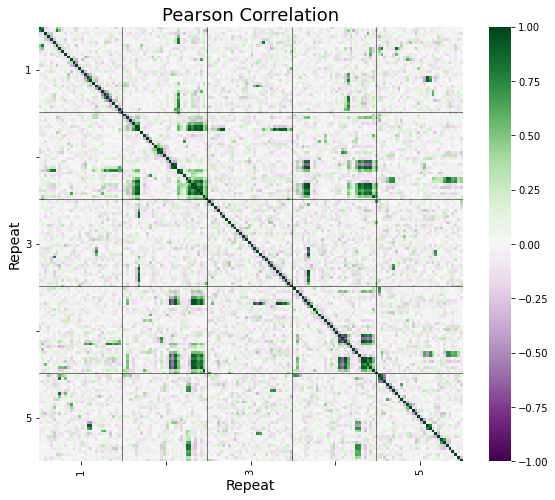

In [14]:
plot_corr(within_session_corrs)

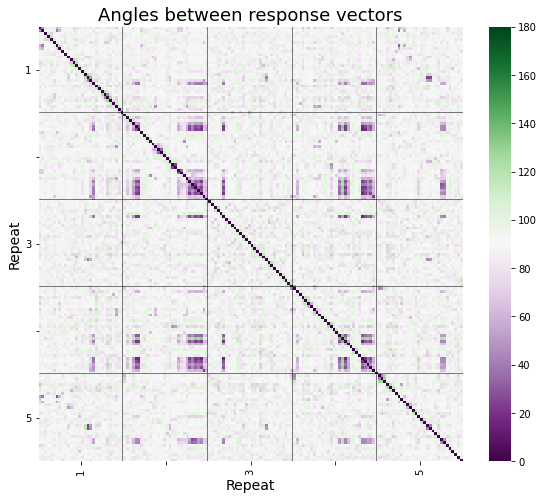

In [15]:
plot_angle(within_session_angles)

__Exploration A) for behavioral correlates:__

Can reorganize repeats sorted by the mean pupil size associated with that repeats:

In [16]:
ppl_size_per_repeat = np.nanmean(ppl_vals, axis = 1)
ppl_repeat_sort_idx = np.argsort(ppl_size_per_repeat)
print(ppl_repeat_sort_idx)

[2 4 0 3 5 6 9 7 1 8]


In [17]:
# reorganize repeats by mean pupil sizes during a movie:
within_session_corrs_ordered = np.zeros((n_repeats*n_divs, n_repeats*n_divs))

for repeat_idx1 in range(n_repeats):
    for repeat_idx2 in range(n_repeats):
        within_session_corrs_ordered[  
            ppl_repeat_sort_idx[repeat_idx1]*n_divs : (ppl_repeat_sort_idx[repeat_idx1]+1)*n_divs,
            ppl_repeat_sort_idx[repeat_idx2]*n_divs : (ppl_repeat_sort_idx[repeat_idx2]+1)*n_divs,
            ] = within_session_corrs[
                repeat_idx1*n_divs : (repeat_idx1+1)*n_divs, 
                repeat_idx2*n_divs : (repeat_idx2+1)*n_divs
            ]

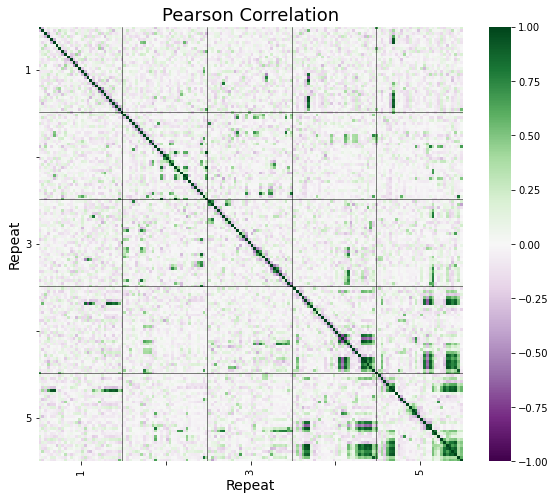

In [18]:
# it does look like there is some more correlation between neighboring repeats:
plot_corr(within_session_corrs_ordered)

__Exploration B)__

Can also plot pupil area difference v.s. the correlation coefficient:

We use only block 1 and block 2 to see whether larger pupil size differences is correlated with smaller correlation coefcients (Sadeh & Clopath, Fig 1b. right).

In [19]:
b1_b2_corr = np.zeros(n_repeats*(n_repeats+1)//2)
ppl_diff = np.zeros(n_repeats*(n_repeats+1)//2)

idx = 0 
for repeat_idx1 in range(n_repeats):
    for repeat_idx2 in range(repeat_idx1, n_repeats):     

        b1_b2_corr[idx] = np.abs(within_session_corrs[
            repeat_idx1*n_divs, repeat_idx2*n_divs +1])
        
        ppl_diff[idx] = np.abs(
            ppl_vals[repeat_idx1, 0] - ppl_vals[repeat_idx2, 1])

        idx += 1

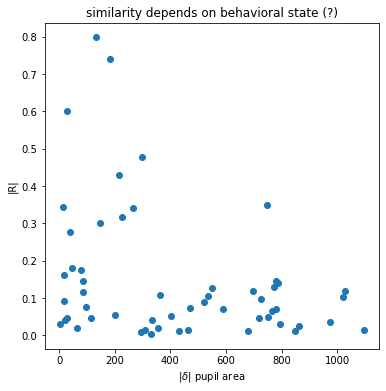

In [20]:
# even very samll data we can kind of see the trend:
_, ax = plt.subplots(figsize = (6,6))
ax.scatter(ppl_diff, b1_b2_corr)
ax.set_xlabel('$|\delta|$ pupil area')
ax.set_ylabel('|R|')
ax.set_title('similarity depends on behavioral state (?)')
plt.show()

-------
### Prettier example (from our sub dataset):


In [21]:
data_set= boc.get_ophys_experiment_data(541206592)
pprint.pprint(data_set.get_metadata())

{'age_days': 130,
 'cre_line': 'Scnn1a-Tg3-Cre/wt',
 'device': 'Nikon A1R-MP multiphoton microscope',
 'device_name': 'CAM2P.1',
 'excitation_lambda': '910 nanometers',
 'experiment_container_id': 540993888,
 'fov': '400x400 microns (512 x 512 pixels)',
 'genotype': 'Scnn1a-Tg3-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt',
 'imaging_depth_um': 350,
 'indicator': 'GCaMP6f',
 'ophys_experiment_id': 541206592,
 'pipeline_version': '3.0',
 'session_start_time': datetime.datetime(2016, 8, 25, 9, 7, 13),
 'session_type': 'three_session_B',
 'sex': 'male',
 'specimen_name': 'Scnn1a-Tg3-Cre;Camk2a-tTA;Ai93-250789',
 'targeted_structure': 'VISp'}


In [22]:
_, dff_traces = data_set.get_dff_traces()
stim_table = data_set.get_stimulus_table('natural_movie_one')

n_cells = dff_traces.shape[0]

dff_vals = np.zeros((n_repeats, n_divs, n_cells))

# for each repeat:
for repeat_idx in range(n_repeats):
    # grab all frames belongs to the repeat
    repeat_frames = np.array(stim_table.query('repeat == @repeat_idx')['start'])
    # for each block:
    for div_idx in range(n_divs):
        # grab block frames
        div_repeat_idxs = repeat_frames[
            div_idx*frames_per_repeat:(div_idx+1)*frames_per_repeat]     
        # average over block frames:
        dff_vals[repeat_idx, div_idx] = np.mean(dff_traces[:, div_repeat_idxs], axis=1)

within_session_corrs, within_session_angles = calc_similarity(dff_vals)

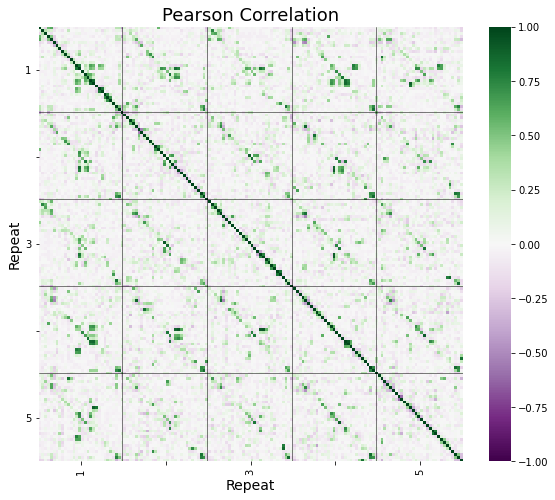

In [23]:
plot_corr(within_session_corrs)

----

### PCA of a stimulus group

Procedure: slice `dff_vals` by block to get a 10x90 data matrix `X`, center and normalize it, and use `PCA` from sklearn on `X.T @ X`.